### 데이터 준비 - kaggle에서 직접 다운받을 수 있지만, 데이터가 바뀌었다고 해서 아이펠에 있는 것을 다운로드하여 사용

In [11]:
# 한번만 실행하면 되는 설치용 코드들
# !pip install kaggle --upgrade
# !kaggle competitions download -c 2019-2nd-ml-month-with-kakr
# !pip install ipywidgets --upgrade


### 평가 기준
1. 작성한 파일 케글에 제출하고 스샷 찍어서 첨부
2. 주피터 노트북 파일 제출
3. 전처리, 학습과정, 최적화, 결과에 대한 주석과 시각화를 포함
4. RMSE 110,000 이하

### 라이브러리 import 및 데이터 EDA

In [29]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv # EDA 라이브러리
import missingno as msno

from datetime import datetime

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [31]:
# 글로벌 변수
SEED = 1004

In [14]:
# 데이터 불러오기 
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# EDA report 생성
# sv.analyze(train).show_html("eda_train.html")
# sv.analyze(test).show_html("eda_test.html")

                                             |          | [  0%]   00:00 -> (? left)

Report eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<Axes: >

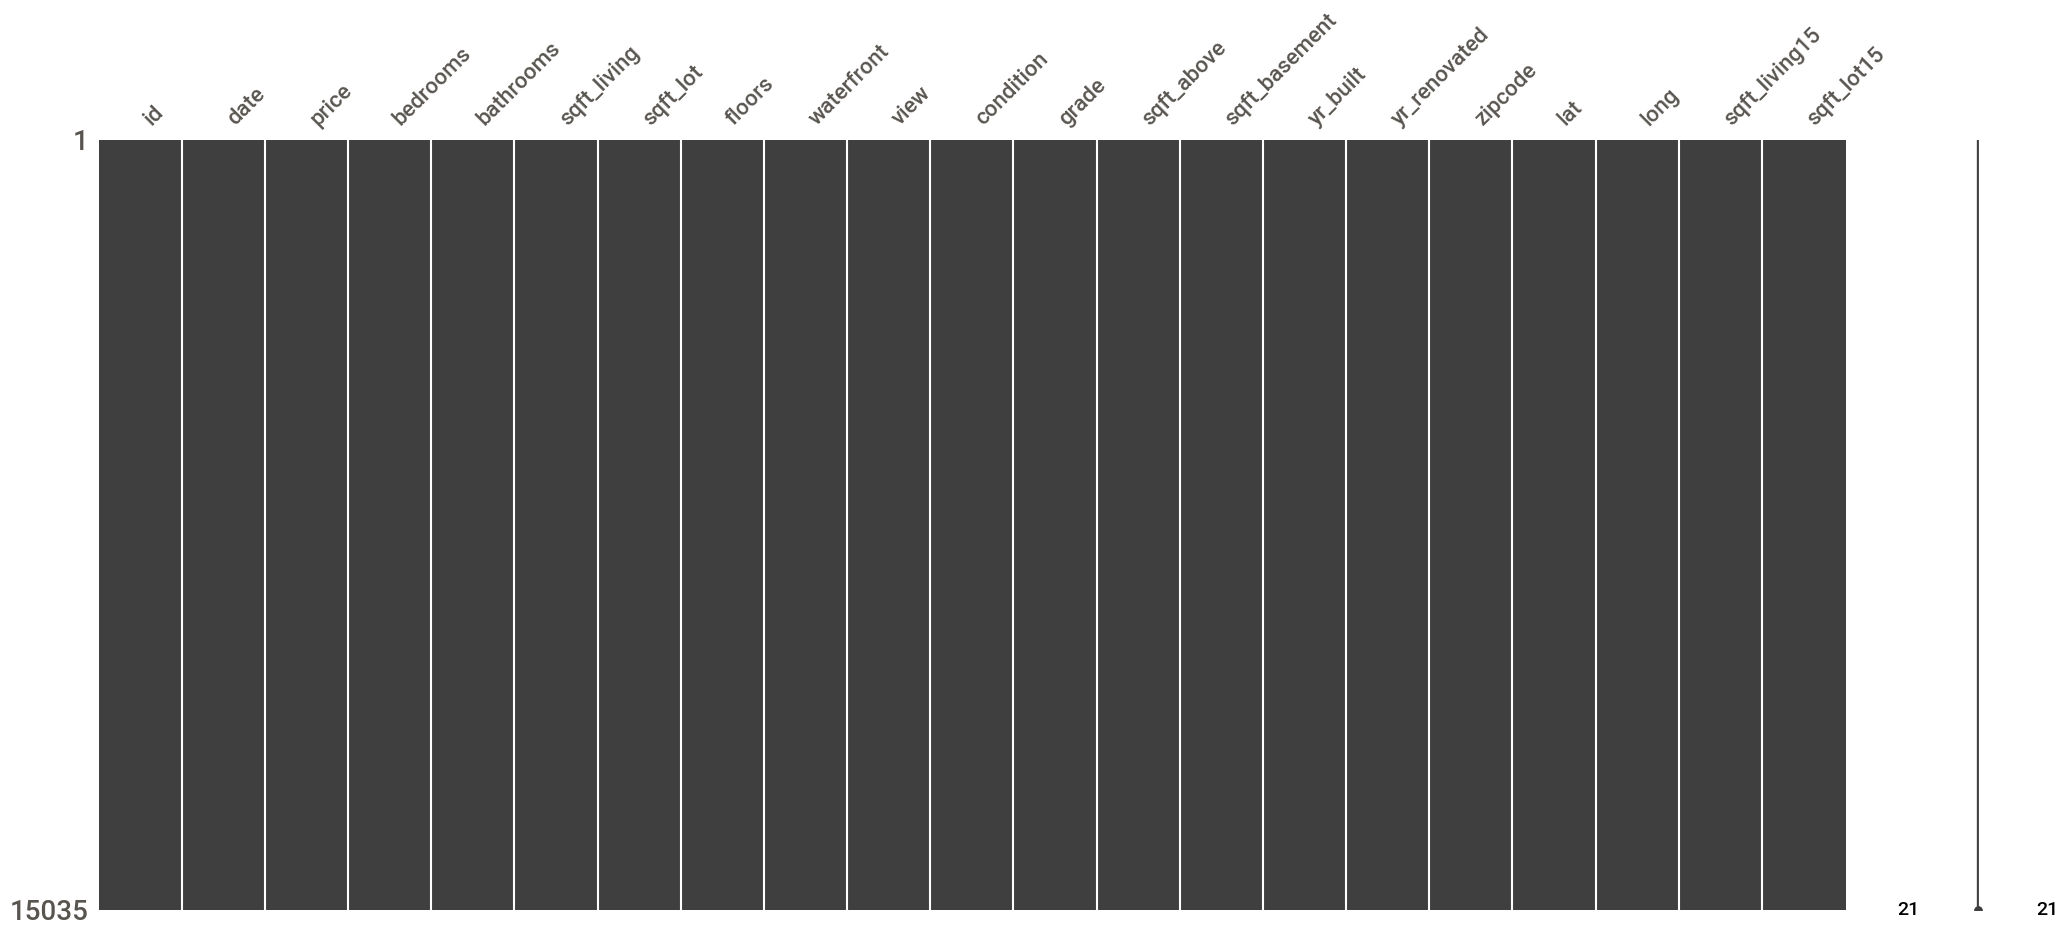

In [15]:
# EDA 
eda_dt = pd.concat([train, test], axis=0)

# EDA report 생성
sv.analyze(eda_dt).show_html("eda_report.html")

# 결측치 한번에 확인 
msno.matrix(train)

### EDA report로 본 상관관계
![](1.png)

In [10]:
## EDA 데이터 확인

## 전반적인 내용  
### 한국 데이터는 아님. 미국 데이터일 듯 
### 아피트, 오피스텔이 아닌 주택 데이터인 듯
### 결측치는 없으나, 0으로 되어 있는 값들이 있어서 확인이 필요 
### id는 중복이 없는걸로 봐서, 조사 시점에 구매한 사람 기준 데이터로 보임 = 전세/월세 처럼 주인이 자주 바뀌는 걸 고려할 필요 없다는 뜻 
### train, test 비율은 7:3

### target : price 값에 skew가 있음. 1/0 구분하는게 아니라서 불균형은 없음. 가격 차이가 꽤 나서, 저가~중가 와 고가를 구분 해주는게 좋을 듯하기도 함 

# ID : 집을 구분하는 번호
# date : 집을 구매한 날짜 - 구매후 지난 시간 등으로 변환 가능
# price : 집의 가격(Target variable) - 달러?
# bedrooms : 침실의 수 - 95%가 5 이하, 35개 있는 곳은 숙박업소일 수도 있음, 0 인 곳은 가격이 낮을 듯
# bathrooms : 화장실의 수 = 95%가 3.5 이하, 8개 있는 곳은 궁전인가?, 0 인 곳은 가격이 낮을 듯
# sqft_living : 주거 공간의 평방 피트(면적) - 궁전이 있는 듯, 2000평이 median
# sqft_lot : 부지의 평방 피트(면적) - 140평이 median, 46,000평인 곳은 농장인가?
# floors : 집의 층 수 0.5단위 , 대부분 2층 이내 
# waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
# view : 집이 얼마나 좋아 보이는지의 정도 - 0~4, 90% 가 1
# condition : 집의 전반적인 상태 - 1~5, 대부분 3~4
# grade : King County grading 시스템 기준으로 매긴 집의 등급, 대부분 6~10
## 미국 워싱턴주에 있는 King County에서 사용하는 평가 방법,  King County Assessor's Office에서 부동산의 상태를 평가하고, 공정한 세금 평가를 보장하기 위해 사용
## 평가 기준
### 건축 품질: 사용된 재료의 품질과 시공 기술을 평가합니다.
### 유지 관리 상태: 주택이 얼마나 잘 유지되고 관리되고 있는지를 평가합니다.
### 갱신 및 개선: 주택의 내부와 외부에서 이루어진 갱신 및 개선 작업의 범위와 품질을 평가합니다.
### 건축 연도와 리모델링 연도
### 내부 및 외부의 주요 구조적 요소 (지붕, 벽, 창문 등)
### 주택의 기능적 요소 (배관, 전기 시스템 등)
### 주택의 미관적 요소 (페인트 상태, 정원 관리 상태 등)
## 등급 기준
### 1~3등급: 매우 낮은 상태의 주택. 건축 품질이 낮고, 유지 관리가 거의 이루어지지 않으며, 큰 수리가 필요할 수 있음.
### 4~6등급: 평균 이하 상태의 주택. 보통의 건축 품질과 유지 관리 상태를 가짐.
### 7~9등급: 평균 상태의 주택. 적절한 건축 품질과 유지 관리 상태를 가짐. 일부 갱신이 있을 수 있음.
### 10~12등급: 평균 이상의 상태의 주택. 높은 품질의 건축 재료와 우수한 유지 관리 상태를 가짐. 갱신 및 개선이 잘 이루어짐.
### 13등급: 매우 우수한 상태의 주택. 최고 품질의 건축 재료와 시공 기술을 사용하고, 매우 철저하게 유지 관리되며, 광범위한 갱신 및 개선이 이루어짐.
# sqft_above : 지하실을 제외한 평방 피트(면적)
# sqft_basement : 지하실의 평방 피트(면적) -> 지하실 유무로 구분해도 될 듯
# yr_built : 지어진 년도 -> 연식으로 구분해도 될 듯
# yr_renovated : 집을 재건축한 년도 -> 재건축 유무로 구분해도 될 듯, 재건축 후 연식으로 구분해도 될 듯
# zipcode : 우편번호
# lat : 위도
# long : 경도
# sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
# sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [19]:
# 전처리
# date : 일시 추출 
train['date'] = train['date'].apply(lambda x :  datetime.strptime(str(x[:8]), '%Y%m%d'))
test['date'] = test['date'].apply(lambda x :  datetime.strptime(str(x[:8]), '%Y%m%d'))

# submission id 빼놓기
test_id = test['id']

# 종속변수 분리
target = train['price']
train.drop('price', axis=1, inplace=True)

In [63]:
# 같은 기준으로 해야 하는 것들 (train, test를 합쳐서 해야함)
all_dt = pd.concat([train, test], axis=0)

# 파생변수 생성
# 구매 후 지난 날짜
max_date = all_dt['date'].max() # 데이터가 수집된 날짜를 알 수 없으므로, 가장 최근 날짜를 기준으로 함
all_dt['after_buy_days'] = all_dt['date'].apply(lambda x : (max_date - x).days)

# 지하실 유무
all_dt['basement_yn'] = all_dt['sqft_basement'].apply(lambda x : 1 if x > 0 else 0)

# 건물 연식
all_dt['after_yr_built'] = all_dt['yr_built'].apply(lambda x : max_date.year - x)

# 재건축 유무
all_dt['renovated_yn'] = all_dt['yr_renovated'].apply(lambda x : 1 if x > 0 else 0)

# 재건축 후 연식
all_dt['after_yr_renovated'] = all_dt['yr_renovated'].apply(lambda x : max_date.year - x if x > 0 else 0)

# datetime 변수 숫자로 변환
all_dt['date'] = all_dt['date'].dt.strftime('%Y%m%d')


In [64]:
# 표준화, 정규화, 분포 변환 (log, sqrt, box-cox?)

# 로그 변환 적용 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
all_dt[skew_columns] =all_dt[skew_columns].apply(lambda x: np.log1p(x))


print(all_dt.info())


<class 'pandas.core.frame.DataFrame'>
Index: 21503 entries, 0 to 6467
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21503 non-null  int64  
 1   date                21503 non-null  object 
 2   bedrooms            21503 non-null  float64
 3   bathrooms           21503 non-null  float64
 4   sqft_living         21503 non-null  float64
 5   sqft_lot            21503 non-null  float64
 6   floors              21503 non-null  float64
 7   waterfront          21503 non-null  int64  
 8   view                21503 non-null  int64  
 9   condition           21503 non-null  int64  
 10  grade               21503 non-null  int64  
 11  sqft_above          21503 non-null  float64
 12  sqft_basement       21503 non-null  float64
 13  yr_built            21503 non-null  int64  
 14  yr_renovated        21503 non-null  int64  
 15  zipcode             21503 non-null  int64  
 16  lat       

In [70]:
# preprocessing 후 report 생성하여 의도 대로 되었는지 확인
eda_after_pre = pd.concat([all_dt, target], axis=1)

sv.analyze(eda_after_pre).show_html("eda_after_pre.html")

                                             |          | [  0%]   00:00 -> (? left)

Report eda_after_pre.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [65]:

# 학습에 사용하지 않을 변수 제거 
use_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'after_buy_days', 'basement_yn', 'after_yr_built', 'renovated_yn', 'after_yr_renovated']

train_use = all_dt[:len(train)][use_cols]
test_use = all_dt[len(train):][use_cols]

In [ ]:
# cv 방식 테스트
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train_use.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train_use.values, y=target, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [67]:


def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x) for m in models
    ])
    return np.mean(predictions, axis=1)

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

get_cv_score(models)

# y_pred = AveragingBlending(models, train_use, target, test_id)
# print(len(y_pred))
# y_pred

Model: GradientBoosting, CV score:0.8626
Model: XGBoost, CV score:0.8751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2721
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2726
[LightGBM] [Info] Number of data poin

In [68]:
# 학습 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(train_use, target, test_size=0.2, random_state=SEED)

# 모델 생성
gboost = GradientBoostingRegressor(random_state=SEED)
xgboost = XGBRegressor(random_state=SEED)
lightgbm = LGBMRegressor(random_state=SEED)
rdforest = RandomForestRegressor(random_state=SEED)

models = [gboost, xgboost, lightgbm, rdforest]

In [69]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # 학습 데이터 분리
    X_train, X_valid, y_train, y_valid = train_test_split(train_use, target, test_size=0.2, random_state=SEED)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_valid)

    # 예측 결과의 rmse값 저장
    df[model_name] = root_mean_squared_error(y_valid, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 23
[LightGBM] [Info] Start training from score 539672.549717


{'GradientBoostingRegressor': 144505.21572184796,
 'XGBRegressor': 141247.59621079004,
 'LGBMRegressor': 126844.13452263847,
 'RandomForestRegressor': 138725.21429789622}

In [42]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

grid_model = GridSearchCV(models[0], param_grid=param_grid, scoring='neg_mean_squared_error',
                            cv=5, verbose=2, n_jobs=5)

# 모델 fitting
grid_model.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1004),
             n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [47]:
# 결과값 저장
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

# 데이터 프레임 생성
results = pd.DataFrame(params)
results['score'] = score

# RMSLE 값 계산 후 정렬
results['RMSLE'] = np.sqrt(-1 * results['score'])
results = results.sort_values('RMSLE')

prediction = grid_model.predict(X_valid)
prediction = np.expm1(prediction)
print(prediction)


FloatingPointError: overflow encountered in expm1

In [44]:
print(results)

   max_depth  n_estimators         score          RMSLE
3         10           100 -1.812307e+10  134621.966141
2         10            50 -1.837509e+10  135554.736268
1          1           100 -3.581588e+10  189250.848598
0          1            50 -4.612577e+10  214769.115553


In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

def get_scores(models, train, y):
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        # [[YOUR CODE]]
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        # [[YOUR CODE]]
        model.fit(X_train, y_train)
        
        # 예측
        # [[YOUR CODE]]
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

get_scores(models, train, y)




# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='root_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [ ]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

my_submission_path = join(data_dir, 'submission.csv')
# [[YOUR CODE]]
result.to_csv(my_submission_path, index=False)

print(my_submission_path)